In [5]:
#from sfdataset import SFDataset
#from model import StyleTransferModel
#from utils import *
import os
import pandas as pd
import numpy as np
import torch
import wandb
import cv2
import time
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
#from torchvision.transforms import Resize,ToTensor,  Compose, InterpolationMode,Normalize,RandomHorizontalFlip,RandomVerticalFlip,RandomCrop
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
import albumentations as A
import random
from PIL import Image
from torchsummary import summary
from tqdm import tqdm
from model import StyleTransferModel
from utils import *
from generator import Generator
from sfdataset import SFDataset

In [3]:
#root="/content/drive/MyDrive/Image Style Transfer/"
data_dir="../../data/"
content_dir=data_dir+"contents/"
style_dir=data_dir+"styles/"
#stylization_dir=data_dir+"stylizations/"

##### Define DataModule

In [6]:
content_list=[name for name in os.listdir(content_dir)]
style_list=[name for name in os.listdir(style_dir)]
pair_list=[(content_dir+a,style_dir+b) for a in content_list for b in style_list]
c_compose=A.Compose([
            A.Resize(512, 512),
            A.RandomCrop(256, 256),
            A.HorizontalFlip(0.4),
            A.VerticalFlip(0.4),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
s_compose=A.Compose([
      A.Resize(512, 512),
      A.RandomCrop(256, 256),
      A.HorizontalFlip(0.4),
      A.VerticalFlip(0.4),
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ToTensorV2()
  ])
train_dataset=SFDataset(pair_list,style_size=256,c_compose=c_compose,s_compose=s_compose)
BATCH_SIZE=8
train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

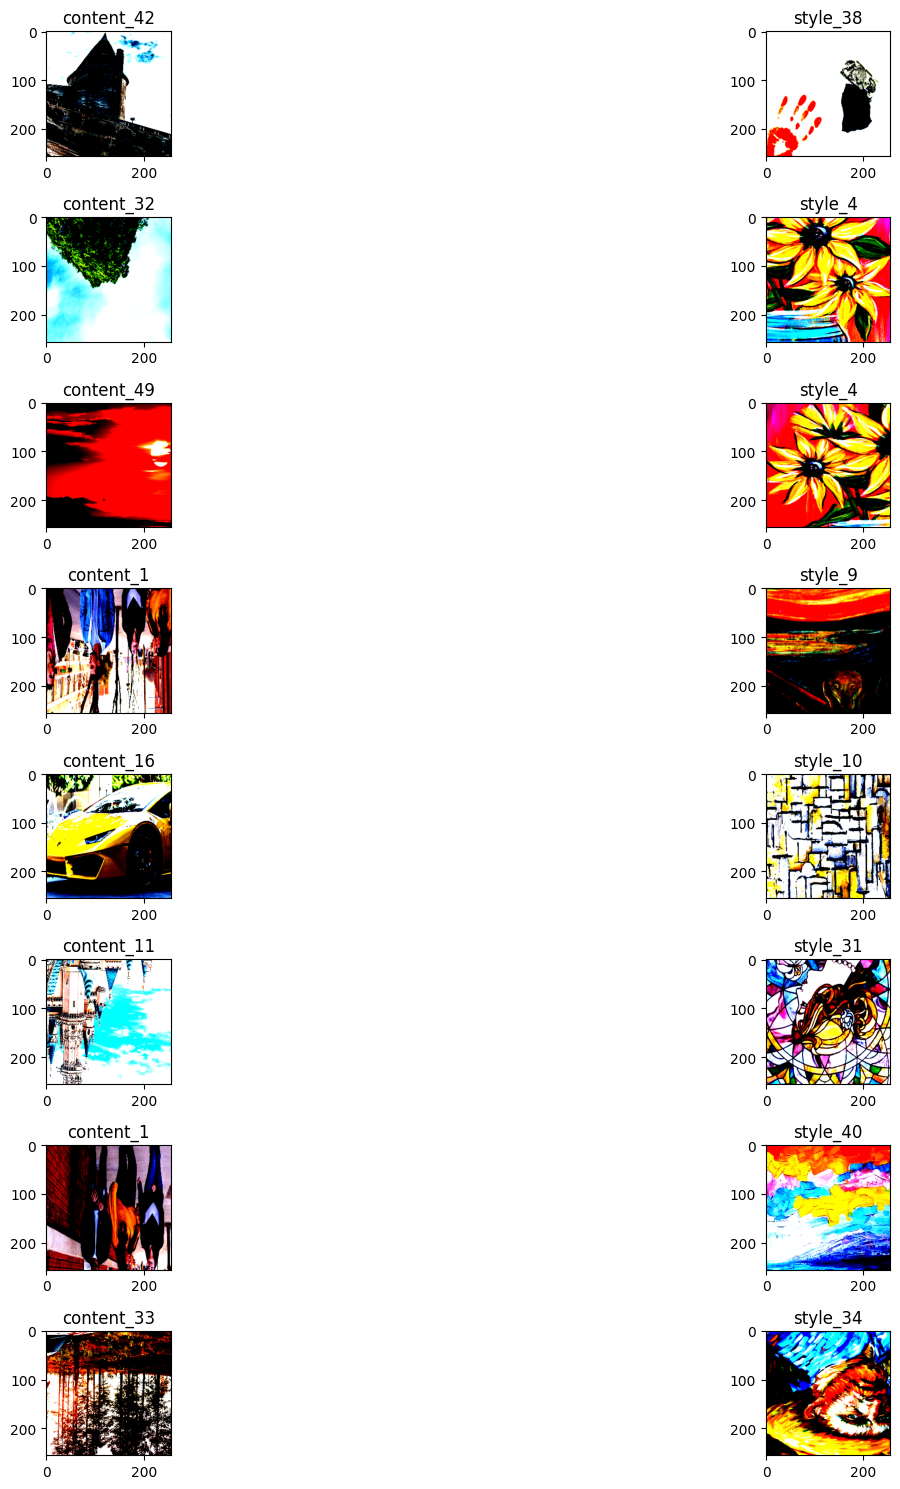

In [5]:
d=next(iter(train_dataloader))
c,s,name=d["content"],d["style"],d["output_name"]
fig,ax=plt.subplots(8,2,figsize=(20,15))
for i in range(c.shape[0]):
  ci,si=c[i].permute(1,2,0).numpy(),s[i].permute(1,2,0).numpy()
  ax[i][0].imshow(ci)
  ax[i][1].imshow(si)
  c_name,s_name=name[i].split('___')[:2]
  ax[i][0].set_title(c_name)
  ax[i][1].set_title(s_name)
plt.tight_layout()
plt.show()

##### Define some utils

In [7]:
import torch
import numpy as np

def compute_mean_std(feats:torch.Tensor,eps=1e-8,infer=False)->torch.Tensor:
    assert(len(feats.shape))==4 #N,C,H,W
    if infer:
        n=1
        c=512
    else:
        n,c,_,_=feats.shape
    feats=feats.view([n,c,-1])
    mean=torch.mean(feats,dim=-1).view(n,c,1,1)
    std=torch.std(feats,dim=-1).view(n,c,1,1)+eps

    return mean,std

def inv_normz(img):
    std=torch.tensor([0.229,0.224,0.225]).reshape(-1,1,1).to(img.device)
    mean=torch.tensor([0.485,0.456,0.406]).reshape(-1,1,1).to(img.device)
    out=torch.clamp(img*std+mean,0,1)
    return out

def normz(img,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]):
    if isinstance(img,np.ndarray):
        img=torch.tensor(img)

    mean=torch.tensor(mean).to(img.device)
    std=torch.tensor(std).to(img.device)

    if mean.ndim==1:
        mean=mean.view(-1,1,1)
    if std.ndim==1:
        std=std.view(-1,1,1)

    return (img-mean)/std

#### Define Trainer

In [8]:
class Trainer():
    def __init__(self,model,optimizer,scheduler,device="auto"):
        self.device=device
        self.__resolve_device()
        self.model=model.to(self.device)
        self.optimizer=optimizer
        self.lr_scheduler=scheduler

    def __resolve_device(self):
        self.device = self.device.lower()
        if self.device == "auto":
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        if self.device == "cuda" and torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"
        print(f"Using device: {self.device.upper()}.")
    def criterion(self,stylized_img,style_img,adain_output,s_weight):
        stylized_content_feature=self.model.encoder_forward(stylized_img,return_last=True)
        stylized_style_feature=self.model.encoder_forward(stylized_img,return_last=False)
        style_feature=self.model.encoder_forward(style_img,return_last=False)
        content_loss=F.mse_loss(stylized_content_feature,adain_output)
        style_loss=0
        for stylized_f,style_f in zip(stylized_style_feature,style_feature):
            stylized_f_mean,stylized_f_std=compute_mean_std(stylized_f)
            style_f_mean,style_f_std=compute_mean_std(style_f)
            style_loss+=F.mse_loss(stylized_f_mean,style_f_mean)+F.mse_loss(stylized_f_std,style_f_std)
        loss=content_loss+s_weight*style_loss
        return loss,content_loss,style_loss
    def train(self,train_loader,num_epoch,save_path,resume_from_checkpoint=None,weight_only=False,alpha=1,s_weight=10):
        #Set up
        start_epoch=0
        best_loss=1000
        if resume_from_checkpoint:
            ckp=torch.load(resume_from_checkpoint)
            self.model.decoder.load_state_dict(ckp["model"])
            if not weight_only:
                self.optimizer.load_state_dict(ckp["optimizer"])
                start_epoch=ckp["epoch"]
                best_loss=ckp["loss"]
        if start_epoch>=num_epoch:
            return

        #Training
        for epoch in range(start_epoch,num_epoch):
            epoch_train_loss=epoch_train_c_loss=epoch_train_s_loss=0
            start_time=time.time()

            self.model.train()
            train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch} (Training)", leave=True, dynamic_ncols=True)

            for i,data in enumerate(train_bar):
                content_input,style_input=data["content"].to(self.device),data["style"].to(self.device)
                final_output,adain_output=self.model(content_input,style_input,alpha=alpha,return_t=True)
                #print(final_output.shape)
                #print(adain_output.shape)
                loss,c_loss,s_loss=self.criterion(final_output,style_input,adain_output,s_weight)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_train_loss+=loss.item()
                epoch_train_c_loss+=c_loss.item()
                epoch_train_s_loss+=s_loss.item()
                train_bar.set_postfix(loss=f"{loss.item():.4f}", c_loss=f"{c_loss.item():.4f}", s_loss=f"{s_loss.item():.4f}", lr=f"{self.optimizer.param_groups[0]['lr']:.6f}")


            end_time=time.time()
            time_taken=end_time-start_time

            epoch_train_loss/=len(train_loader)
            epoch_train_c_loss/=len(train_loader)
            epoch_train_s_loss/=len(train_loader)

            self.lr_scheduler.step()

            print(f"DONE EPOCH {epoch}: ")
            print(f"\tTrain loss: {epoch_train_loss:.4f} | Time taken: {time_taken:.4f} |")
            print(f"\tTrain content loss: {epoch_train_c_loss:.4f}  ")
            print(f"\tTrain style loss: {epoch_train_s_loss:.4f}  ")
            if epoch_train_loss<best_loss:
                best_loss=epoch_train_loss
                checkpoint={
                    'epoch': epoch,
                    'model': self.model.decoder.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    'loss': best_loss,
                }
                torch.save(checkpoint,save_path)
            """wandb.log({
            "epoch": epoch,
            "train_loss": epoch_train_loss,
            "train_content_loss":epoch_train_c_loss,
            "train_style_loss":epoch_train_s_loss,
            })
        wandb.finish()"""

In [9]:
model=StyleTransferModel()
lr=1e-4
optimizer=optim.Adam(model.decoder.parameters(),lr=lr)
#scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5,patience=4,min_lr=1e-6)
scheduler=optim.lr_scheduler.PolynomialLR(optimizer,total_iters=50,power=2)

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


81fee4350d7b56c168d02c940c943f555a6c2e31

In [10]:
trainer=Trainer(model,optimizer,scheduler=scheduler)

Using device: CUDA.


In [11]:
NUM_EPOCH=100
save_path=f'./model.pth'
ckp_to_resume="../../models/model-ckp176.pth"#"./model.pth"#"/kaggle/input/adain-model/model-ckp100.pth"
trainer.train(train_dataloader,NUM_EPOCH,save_path,resume_from_checkpoint=ckp_to_resume,weight_only=False)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_36320\3833625373.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp=torch.load(resume_from_checkpoint)
Epoch 76/100 (Traini

KeyboardInterrupt: 

In [12]:
!zip -r my_results.zip model.pth

	zip warning: name not matched: /model.pth

zip error: Nothing to do! (try: zip -r my_results.zip . -i /model.pth)


#### Inference

In [12]:
model_path="../../models/model-ckp176.pth"
model=StyleTransferModel(ckp=model_path).cuda()

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ADMIN\OneDrive - Hanoi University of Science and Technology\coding\cv\Style Transfer Project\src\adain\model.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See

In [13]:
generator=Generator(model,device="auto",color_retention_ratio=1.0)
save_output_dir="../../outputs/adain"
def visualize(content_img, style_img, output_img):
        """
        Visualize content, style, and output images using matplotlib.

        Args:
            content_img (np.ndarray): Content image array.
            style_img (np.ndarray): Style image array.
            output_img (PIL.Image): Stylized output image.
        """
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

        ax[0].imshow(content_img)
        ax[0].set_title("Content")
        ax[0].axis("off")

        ax[1].imshow(style_img)
        ax[1].set_title("Style")
        ax[1].axis("off")

        ax[2].imshow(output_img)
        ax[2].set_title("Output")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()

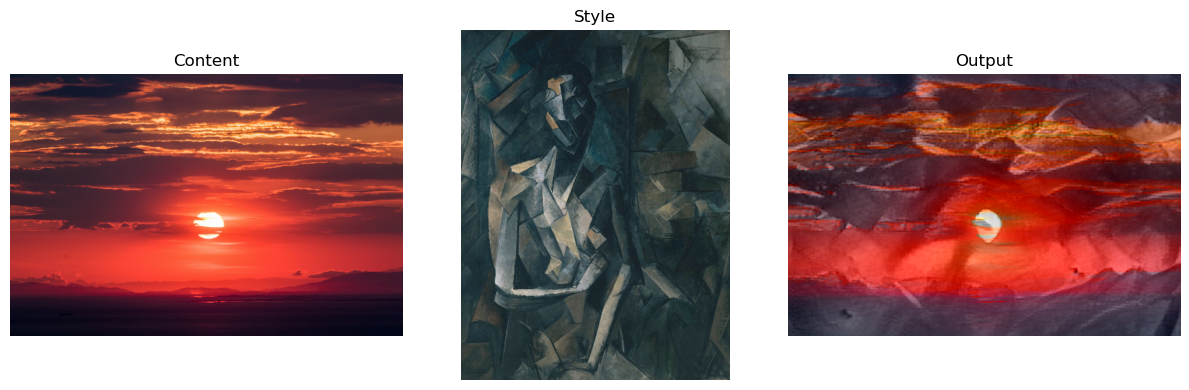

In [56]:
c_list=[content_dir+name for name in os.listdir(content_dir)]
s_list=[style_dir+name for name in os.listdir(style_dir)]
random_c_path=random.choice(c_list)
random_s_path=random.choice(s_list)
output_img=generator.generate_for_a_single_sample(content_img_path=random_c_path,style_img_path=random_s_path,alpha=0.8)
content_img=np.array(Image.open(random_c_path).convert("RGB"))
style_img=np.array(Image.open(random_s_path).convert("RGB"))
visualize(content_img,style_img,output_img)

In [25]:
generator.generate(train_dataloader,save_dir=save_output_dir,num_to_vis=5,alpha=1.0)

Generating and saving stylized images...
Done generating and saving!
Visualizing 5 samples...


TypeError: Generator.visualize_samples() missing 1 required positional argument: 'num_samples'